In [7]:
# ==============================================================================
# 1. IMPORTING NECESSARY LIBRARIES
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    auc
)

# Set plot style
sns.set_style('whitegrid')



In [8]:
# ==============================================================================
# 2. LOADING THE DATA
# ==============================================================================
try:
    df = pd.read_csv('creditcard.csv')
    print("Dataset loaded successfully.")
    print("Dataset shape:", df.shape)
    print("\nFirst 5 rows of the dataset:")
    print(df.head())
except FileNotFoundError:
    print("Error: 'creditcard.csv' not found. Please ensure the dataset is in the correct directory.")
    exit()



Dataset loaded successfully.
Dataset shape: (284807, 31)

First 5 rows of the dataset:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ...


Class Distribution:
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


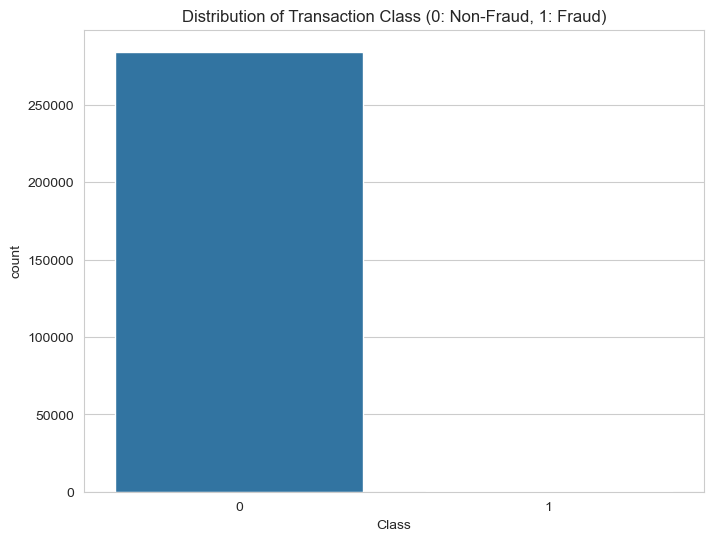

C:\Users\Agrim Singh\AppData\Local\Temp\ipykernel_30492\1718493547.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Time_of_Day', data=df[df['Class'] == 1], order=['Morning', 'Afternoon', 'Evening', 'Night'], palette='viridis')


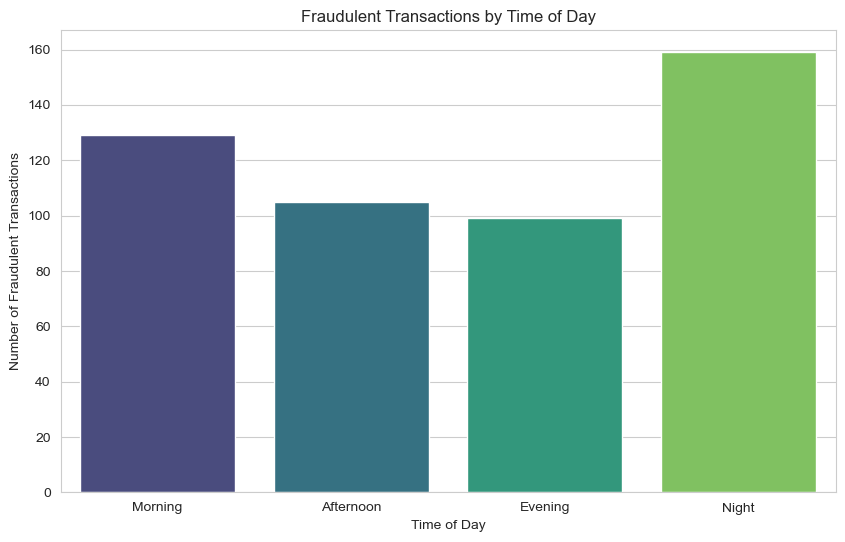

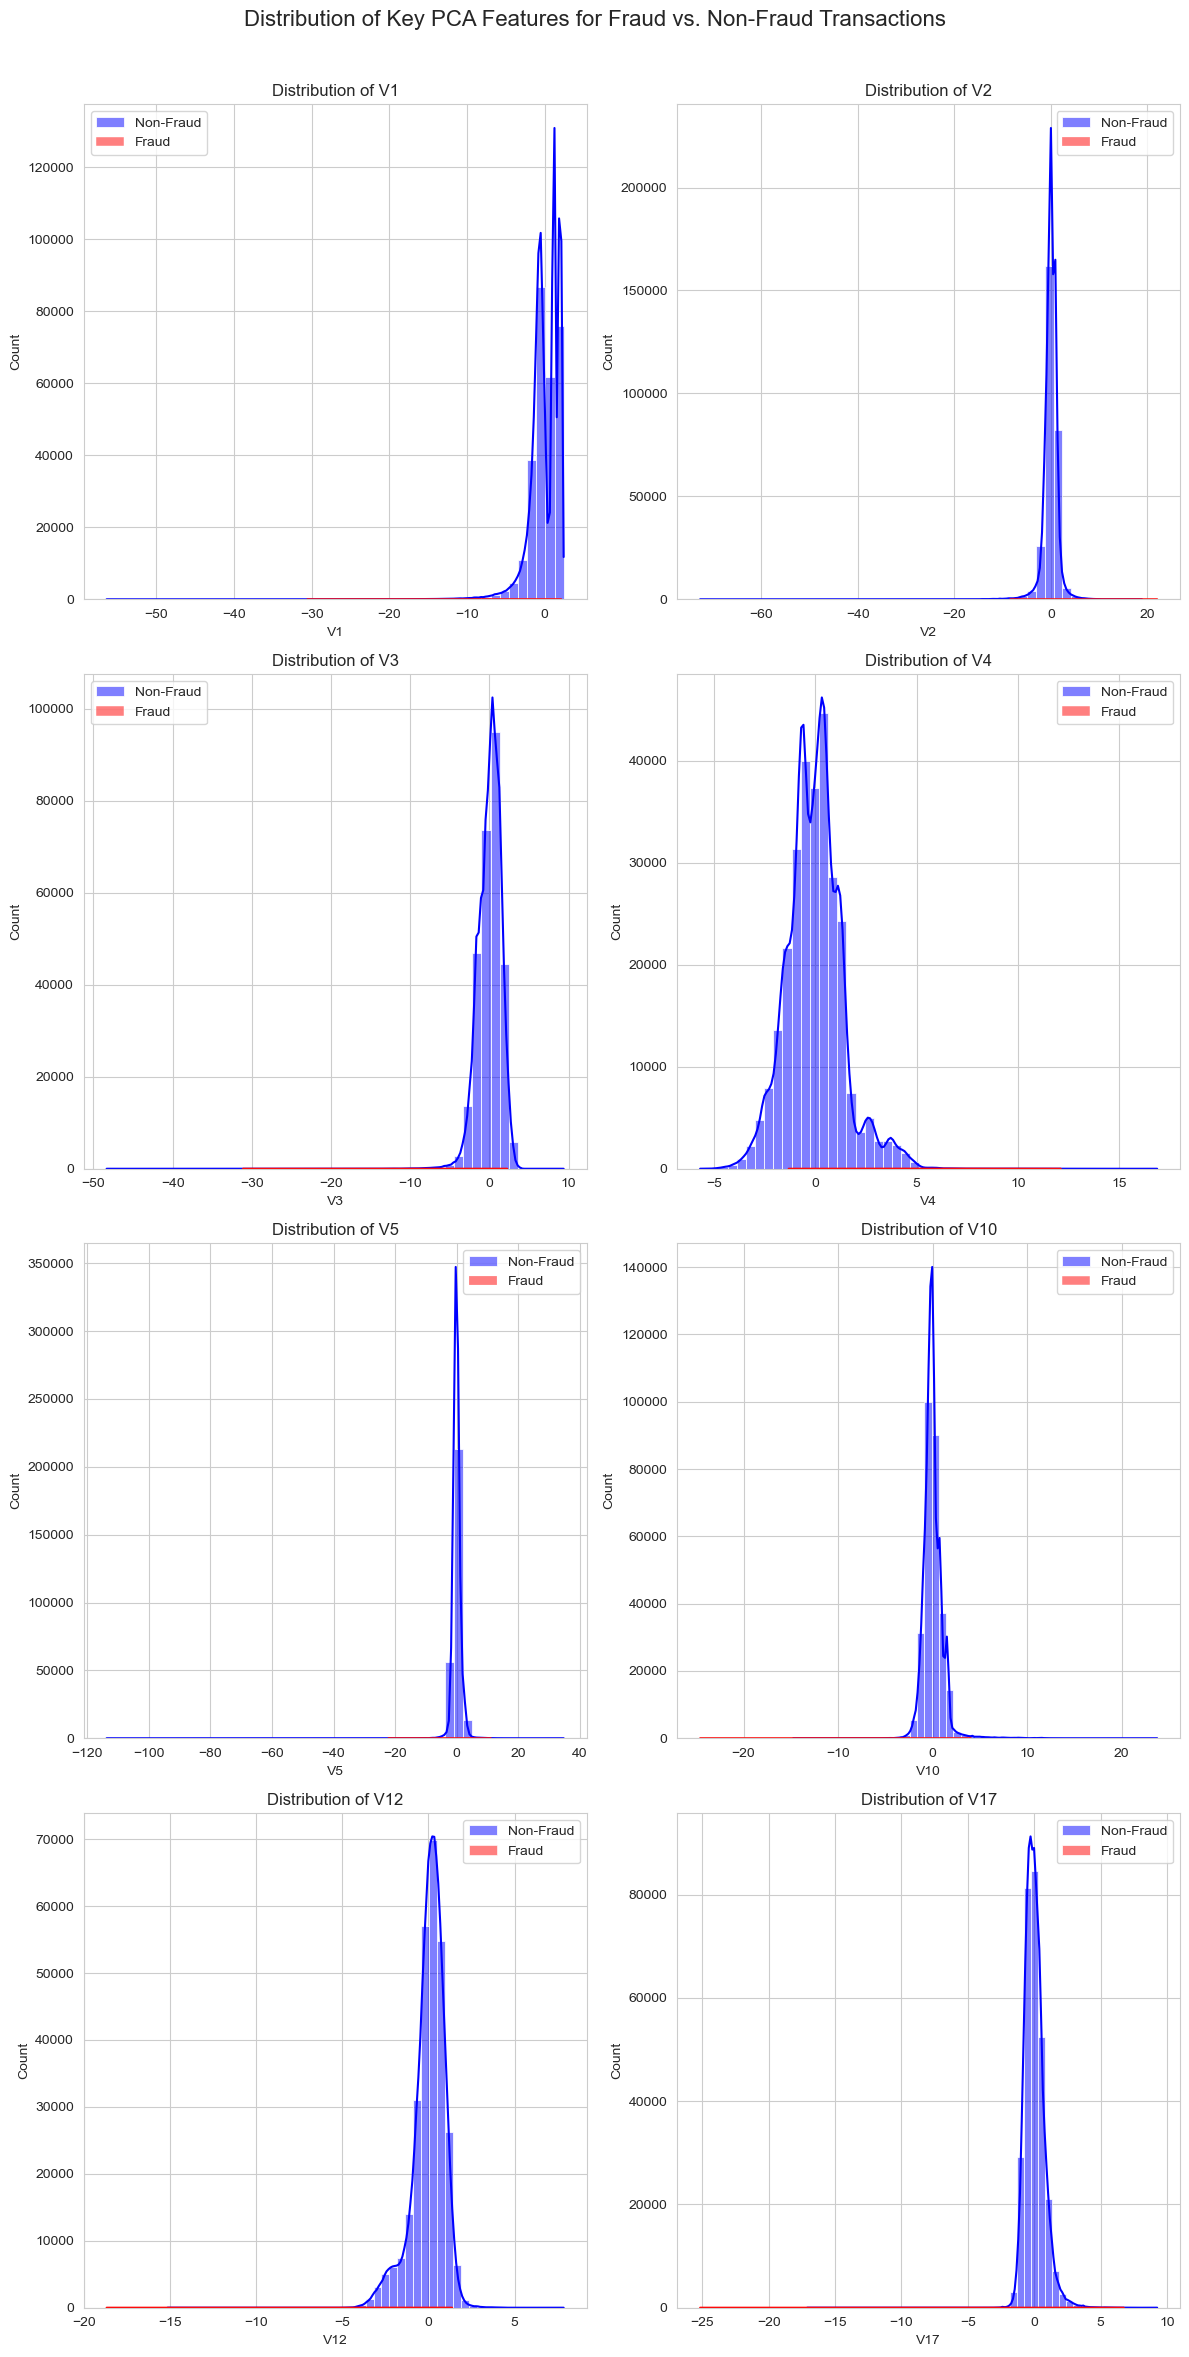

In [9]:
# ==============================================================================
# 3. EXPLORATORY DATA ANALYSIS (EDA)
# ==============================================================================

# --- Class Distribution ---
print("\nClass Distribution:")
print(df['Class'].value_counts(normalize=True))

plt.figure(figsize=(8, 6))
sns.countplot(x='Class', data=df)
plt.title('Distribution of Transaction Class (0: Non-Fraud, 1: Fraud)')
plt.show()


# --- Feature Engineering and Analysis of 'Time' ---
# Convert 'Time' from seconds to hours for better interpretability
df['Time_Hour'] = df['Time'] / 3600

# Create a 'Time_of_Day' feature
def get_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df['Time_of_Day'] = (df['Time_Hour'] % 24).apply(get_time_of_day)

# Visualize fraud counts by 'Time of Day'
plt.figure(figsize=(10, 6))
sns.countplot(x='Time_of_Day', data=df[df['Class'] == 1], order=['Morning', 'Afternoon', 'Evening', 'Night'], palette='viridis')
plt.title('Fraudulent Transactions by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Number of Fraudulent Transactions')
plt.show()


# --- Visualize PCA Feature Distributions ---
# Plotting distributions for a subset of V features for brevity
v_features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V10', 'V12', 'V17']
plt.figure(figsize=(12, len(v_features) * 3))
plt.suptitle('Distribution of Key PCA Features for Fraud vs. Non-Fraud Transactions', fontsize=16)

for i, col in enumerate(v_features, 1):
    plt.subplot(len(v_features)//2, 2, i)
    sns.histplot(df[col][df['Class'] == 0], color='blue', kde=True, label='Non-Fraud', bins=50)
    sns.histplot(df[col][df['Class'] == 1], color='red', kde=True, label='Fraud', bins=50)
    plt.title(f'Distribution of {col}')
    plt.legend()
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()



In [10]:
# ==============================================================================
# 4. DATA PREPROCESSING
# ==============================================================================
print("\nStarting data preprocessing...")

# Scale 'Amount' and 'Time' features
scaler = StandardScaler()
df['scaled_Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_Time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))

# Drop original 'Time', 'Amount', and the intermediate time columns
df.drop(['Time', 'Amount', 'Time_Hour', 'Time_of_Day'], axis=1, inplace=True)

print("Data preprocessing complete.")




Starting data preprocessing...
Data preprocessing complete.


In [11]:
# ==============================================================================
# 5. TRAIN-TEST SPLIT
# ==============================================================================

# Define features (X) and target (y)
X = df.drop('Class', axis=1)
y = df['Class']

# Split the data into training and testing sets, using stratify for imbalanced data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("\nOriginal training set shape: %s" % Counter(y_train))




Original training set shape: Counter({0: 227451, 1: 394})


In [12]:
# ==============================================================================
# 6. HANDLING CLASS IMBALANCE
# ==============================================================================
# We will use SMOTE (Synthetic Minority Over-sampling Technique)
# It's generally preferred over simple random oversampling

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Resampled (SMOTE) training set shape: %s" % Counter(y_train_resampled))



Resampled (SMOTE) training set shape: Counter({0: 227451, 1: 227451})


In [13]:
# ==============================================================================
# 7. HYPERPARAMETER TUNING WITH GRIDSEARCHCV
# ==============================================================================
print("\nStarting hyperparameter tuning for XGBoost...")

# Define a smaller, more focused parameter grid for faster execution
param_grid = {
    'learning_rate': [0.1],
    'n_estimators': [200],
    'max_depth': [3, 5],
    'gamma': [0.1, 0.3]
}

# Initialize the XGBoost classifier
# `use_label_encoder=False` and `eval_metric='logloss'` are used to avoid deprecation warnings
xgb = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='roc_auc',  # Use ROC-AUC for scoring, suitable for imbalanced data
    n_jobs=-1,          # Use all available CPU cores
    cv=3,               # 3-fold cross-validation
    verbose=2
)

# Fit the grid search to the resampled data
grid_search.fit(X_train_resampled, y_train_resampled)

# Print the best parameters and best score
print("\nBest parameters found: ", grid_search.best_params_)
print("Best cross-validation ROC-AUC score: ", grid_search.best_score_)




Starting hyperparameter tuning for XGBoost...
Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\Agrim Singh\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:57:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Best parameters found:  {'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best cross-validation ROC-AUC score:  0.999969307035847



Evaluating the final model on the test set...

--- Classification Report ---
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     56864
       Fraud       0.48      0.88      0.62        98

    accuracy                           1.00     56962
   macro avg       0.74      0.94      0.81     56962
weighted avg       1.00      1.00      1.00     56962


--- Confusion Matrix ---


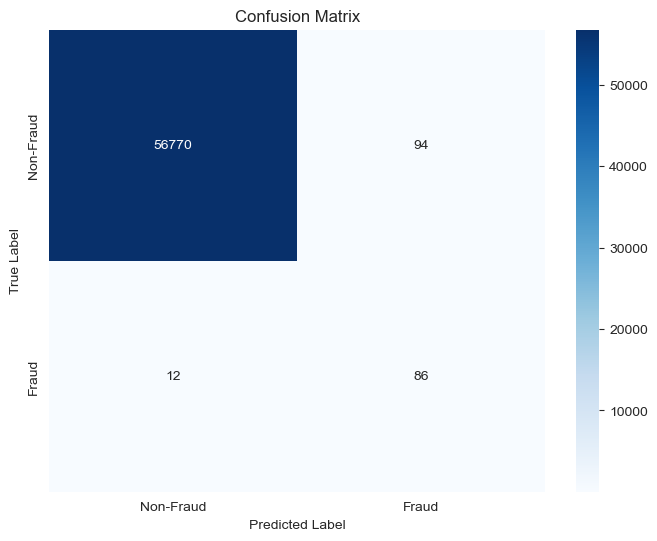


Final Model ROC-AUC Score on Test Set: 0.9792


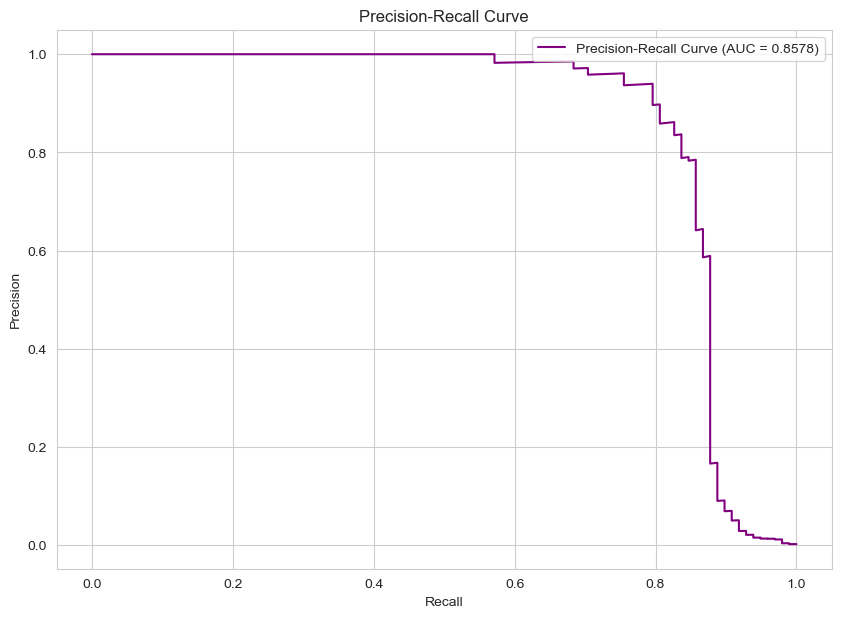


--- End of Analysis ---


In [14]:
# ==============================================================================
# 8. FINAL MODEL EVALUATION
# ==============================================================================
print("\nEvaluating the final model on the test set...")

# Get the best estimator from the grid search
best_xgb = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_xgb.predict(X_test)
y_pred_proba = best_xgb.predict_proba(X_test)[:, 1]

# --- Classification Report ---
# This gives precision, recall, and F1-score for each class
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['Non-Fraud', 'Fraud']))

# --- Confusion Matrix ---
print("\n--- Confusion Matrix ---")
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# --- ROC-AUC Score ---
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nFinal Model ROC-AUC Score on Test Set: {roc_auc:.4f}")

# --- Precision-Recall Curve ---
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

plt.figure(figsize=(10, 7))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {pr_auc:.4f})', color='purple')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

print("\n--- End of Analysis ---")